<a href="https://colab.research.google.com/github/oscarserc/Reinforcement-Learning-y-Simulacion-Social/blob/main/Prueba_1_QLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **1). Cargamos algunas librerías empleadas en la creación de agentes y fijamos los valores de los parámetros.** 

In [ ]:
# Importamos las LIBRERÍAS
import numpy as np
import pandas as pd
import random

# En primer lugar procedemos a especificar los parámetros que se emplearán a lo largo del
# PROGRAMA
# =======================================================================================
# PARÁMETROS
# ----------
alfa    = 0.1     # TASA DE APRENDIZAJE
gamma   = 0.1     # TASA DE DESCUENTO
epsilon = 0.2     # probabilidad de EXPLORACIÓN
num_estados  = 3  # EMOCIONES - Inicialmente 3 
num_acciones = 2  # Cooperar o NoCooperar

# Recompensas intrínsecas
r_alegria      = 3
r_ira          = 2
r_culpabilidad = 2

# TAMAÑO DE LA CUADRICULA (Grid) - Por ejemplo: (size=10)  =>  (10 filas x 10 columnas)
size = 10


## **2). Definimos las clases principales que intervienen en el programa**

In [ ]:
# CLASES PRINCIPALES
# ==================

# 1) Clase AGENTE  >>> Primera prueba: (Agente con exploración epsilon-greedy)
# ---------------
class AgenteEmocional(object):
  def __init__(self, alfa=0.1, gamma=0.1):
     self.alfa     = alfa
     self.gamma    = gamma
     self.estados  = num_estados
     self.acciones = num_acciones
     self.num_vecinos           = 0
     
     # RECOMPENSAS y GANANCIAS
     # -----------------------
     self.recompensa            = 0
     self.recompensa_intrinseca = 0
     self.ganancias             = []
     
     # ESTADOS EMOCIONALES (S y S')
     # ----------------------------
     self.emocion               = np.random.randint(num_estados) # Emocion inicial
     self.emocion_tras_jugada   = 0                              # Un valor cualquiera, se modificará de inmediato
     
     # DECISIONES
     # ----------
     self.accion_propia         = 0  # Un valor cualquiera, se modificará de inmediato
     self.accion_vecindario     = 0  # Un valor cualquiera, se modificará de inmediato
     self.numero_cooperadores   = 0 

     # PROCESO DE APRENDIZAJE
     # ----------------------
     self.matriz_Q = np.zeros((num_estados, num_acciones))
     self.ERRORES               = []

  def Fijar_vecinos(self,vecinos):
    self.num_vecinos = vecinos

  def Vecinos(self):
    return self.num_vecinos  

  def Fijar_num_cooperadores(self, numero):
    self.numero_cooperadores = numero

  def Fijar_intensidad_emocional(self, intensidad):
    self.intensidad_emocional = intensidad

  def Q(self):
    return self.matriz_Q


  # DECISIONES: epsilon-greedy
  def Tomar_decision(self, estado):
    valor_aleatorio = np.random.uniform(0,1)

    if valor_aleatorio < epsilon:
      accion = np.random.randint(num_acciones)
      self.accion_propia = accion
    else:
      Qs = self.matriz_Q[estado]  
      accion = np.argmax(Qs)  
      self.accion_propia = accion 

    return accion


  def Accion(self):
    return self.accion_propia

  def Accion_vecindario(self, accion_vecinos):
    self.accion_vecindario = accion_vecinos

  def Recompensa(self, recompensa):
    self.recompensa = recompensa

  def nuevo_estado(self, accion_vecindario):
    ALEGRIA      = 0
    IRA          = 1
    CULPABILIDAD = 2

    COOPERAR     = 1
    No_COOPERAR  = 0

    # Partimos de Estado inicial: ALEGRÍA  ('0')
    # ---------------------------
    if ((self.emocion == ALEGRIA) and (self.accion_propia == COOPERAR)):              # Está ALEGRE y COOPERA
       if (self.accion_vecindario == 1):           #  <---------  Vecinos COOPERAN
         self.emocion_tras_jugada   = ALEGRIA
         self.recompensa_intrinseca = r_alegria
       else:                                       #  <---------  Vecinos No COOPERAN
         self.emocion_tras_jugada   = IRA      
         self.recompensa_intrinseca = 0  
    elif ((self.emocion == ALEGRIA) and (self.accion_propia == No_COOPERAR)):      # Está ALEGRE y NoCOOPERA
       if (self.accion_vecindario == COOPERAR):
         self.emocion_tras_jugada   = CULPABILIDAD
         self.recompensa_intrinseca = 0
       else:
         self.emocion_tras_jugada   = ALEGRIA      
         self.recompensa_intrinseca = 0  

    # Partimos de Estado inicial: IRA  ('1')
    # ---------------------------
    if (self.emocion == IRA) and (self.accion_propia == COOPERAR):                 # Está IRACUNDO y COOPERA
       if (self.accion_vecindario == COOPERAR):     #  <---------  Vecinos COOPERAN
         self.emocion_tras_jugada   = IRA
         self.recompensa_intrinseca = 0
       else:                                        #  <---------  Vecinos No COOPERAN
         self.emocion_tras_jugada   = IRA      
         self.recompensa_intrinseca = 0  
    elif (self.emocion == IRA) and (self.accion_propia == No_COOPERAR):          # Está IRACUNDO y NoCOOPERA
       if (self.accion_vecindario == COOPERAR):     #  <---------  Vecinos COOPERAN
         self.emocion_tras_jugada   = CULPABILIDAD
         self.recompensa_intrinseca = 0
       else:                                        #  <---------  Vecinos No COOPERAN
         self.emocion_tras_jugada   = IRA      
         self.recompensa_intrinseca = r_ira  

    # Partimos de Estado inicial: CULPABILIDAD  ('2')
    # ---------------------------
    if (self.emocion == CULPABILIDAD) and (self.accion_propia == COOPERAR):        # Siente CULPABILIDAD y COOPERA
       if (self.accion_vecindario == COOPERAR):     #  <---------  Vecinos COOPERAN
         self.emocion_tras_jugada   = ALEGRIA
         self.recompensa_intrinseca = r_culpabilidad
       else:                                        #  <---------  Vecinos No COOPERAN
         self.emocion_tras_jugada   = IRA      
         self.recompensa_intrinseca = 0  
    elif (self.emocion == CULPABILIDAD) and (self.accion_propia == No_COOPERAR): # Siente CULPABILIDAD y NoCOOPERA
       if (self.accion_vecindario == COOPERAR):     #  <---------  Vecinos COOPERAN
         self.emocion_tras_jugada   = CULPABILIDAD
         self.recompensa_intrinseca = 0
       else:                                        #  <---------  Vecinos COOPERAN
         self.emocion_tras_jugada   = IRA     
         self.recompensa_intrinseca = 0  

    return self.emocion_tras_jugada

   
  def paso_aprendizaje(self):
    # ESTADOS:    s (estado) y s' (estado_nuevo)
    estado = self.emocion
    estado_nuevo = self.nuevo_estado(self.accion_vecindario)
    # RECOMPENSA: r
    r = self.recompensa + self.recompensa_intrinseca
    # ACCIÓN:     a (accion) y a' (accion_nueva)
    accion = self.accion_propia
    accion_nueva = self.Tomar_decision(estado_nuevo)

    # Seguimos el rastro de las recompensas que recibe
    self.ganancias.append(r)

    # --------------------
    # Algoritmo Q-Learning
    # --------------------
    # APRENDIZAJE:
    target = float(r) + gamma * self.matriz_Q[estado_nuevo].max()  
    error  = target - self.matriz_Q[estado][accion]
    self.ERRORES.append(error)
    self.matriz_Q[estado][accion] = self.matriz_Q[estado][accion] + (alfa*error)

    self.emocion = estado_nuevo


# 2) Clase AMBIENTE
# -----------------
# Esta clase debe enviar: (s,r)
# Es decir: el estado siguiente (s) - o la información para determinarlo -
# (en este caso las estrategias de los otros jugadores)
# y además la RECOMPENSA DEL DILEMA (r)
class Environment(object):
  def __init__(self, size_):
    self.matriz_pagos_J1 = np.zeros((2,2))
    self.matriz_pagos_J2 = np.zeros((2,2))

    # MATRIZ DE PAGOS del Jugador 1 (índice: 0/1 = NoCooperar/Cooperar)
    self.matriz_pagos_J1[0][0] = 0   
    self.matriz_pagos_J1[0][1] = 5
    self.matriz_pagos_J1[1][0] = 0   
    self.matriz_pagos_J1[1][1] = 3

    # MATRIZ DE PAGOS del Jugador 2 (índice: 0/1 = NoCooperar/Cooperar)
    self.matriz_pagos_J2[0][0] = 0   
    self.matriz_pagos_J2[0][1] = 0
    self.matriz_pagos_J2[1][0] = 5   
    self.matriz_pagos_J2[1][1] = 3

    self.size = size_
    self.Grid = np.full((size + 2, size + 2), AgenteEmocional)

    # PROBAMOS A INCLUIRLO EN EL __init__. Antes: def inicializar_tablero(self):
    # ASIGNAMOS VECINOS al crear OBJETOS (Para graduar la intensidad emocional)
    # ----------------------------------
    # · AL INTERIOR DEL TABLERO:            <-------------- 8 VECINOS
    for i in range(size+2):
      for j in range(size+2):
        self.Grid[i][j] = AgenteEmocional() 
        if ((i>1 and i<size) and (j>1 and j<size)):
          self.Grid[i][j].Fijar_vecinos(8)  
        else:
          self.Grid[i][j].Fijar_vecinos(0)

    # · A LAS ESQUINAS                      <-------------- 3 VECINOS
    self.Grid[1][1].Fijar_vecinos(3)
    self.Grid[size][size].Fijar_vecinos(3)
    self.Grid[size][1].Fijar_vecinos(3)
    self.Grid[1][size].Fijar_vecinos(3)

    # · AL BORDE                            <-------------- 5 VECINOS
    for columna in range(2,size,+1): self.Grid[1][columna].Fijar_vecinos(5)
    for columna in range(2,size,+1): self.Grid[size][columna].Fijar_vecinos(5)
    for fila in range(2,size,+1):    self.Grid[fila][1].Fijar_vecinos(5)
    for fila in range(2,size,+1):    self.Grid[fila][size].Fijar_vecinos(5)


  def Devolver_Grid(self):
    return self.Grid


  def step(self):
    num_cooperadores = 0
    reward           = 0
    Vecinos_Cooperan = 0
    filas    = size
    columnas = size
    recompensa = 0

    acciones   = np.zeros((size+2, size+2),dtype=int)
    emociones  = np.zeros((size+2, size+2),dtype=int)
    intensidad = np.zeros((size+2, size+2))

    # Aquí cada AGENTE toma su DECISIÓN:
    for i in range(1,filas+1,+1):
      for j in range(1,columnas+1,+1):
        # ESTO CONSTITUIRÁ EL 'FRAME' con las acciones en un paso 
        estado            = self.Grid[i][j].emocion
        #acciones[i][j]    = self.Grid[i][j].Tomar_decision(estado) 
        acciones[i][j]    = self.Grid[i][j].Accion()                                               #   (A)
        emociones[i][j]   = self.Grid[i][j].emocion                                                #   (E)


    # Ahora recopilamos todos los resultados del ENTORNO para enviar al AGENTE
    for i in range(1,size+1,+1):
      for j in range(1,size+1,+1):
         cooperadores = self.Grid[i-1][j-1].Accion() + self.Grid[i-1][j].Accion() + self.Grid[i-1][j+1].Accion() + \
                        self.Grid[i][j-1].Accion()   +                              self.Grid[i][j+1].Accion()   + \
                        self.Grid[i+1][j-1].Accion() + self.Grid[i+1][j].Accion() + self.Grid[i+1][j+1].Accion() 

         grado_unanimidad_cooperacion = (cooperadores / self.Grid[i][j].Vecinos())

         if (grado_unanimidad_cooperacion > 0.5):
           Vecinos_Cooperan = 1
         self.Grid[i][j].Accion_vecindario(Vecinos_Cooperan)
         self.Grid[i][j].Fijar_intensidad_emocional(grado_unanimidad_cooperacion)
         # LA OTRA MATRIZ QUE TENEMOS QUE EMPLEAMOS 
         intensidad[i][j] = grado_unanimidad_cooperacion                                           # (I)
         a_J1 = acciones[i][j]   
         a_J2 = Vecinos_Cooperan
         self.Grid[i][j].Fijar_num_cooperadores(cooperadores)  
         self.Grid[i][j].Recompensa(self.matriz_pagos_J1[a_J1][a_J2])  
         self.Grid[i][j].paso_aprendizaje()

    return acciones, emociones, intensidad     


## **3). Creamos una instancia del entorno y realizamos algunos ciclos para comprobar cómo se comporta el ERROR**

In [ ]:

env = Environment(size)

# CONJUNTO de 200 CICLOS
for _ in range(2000):
  env.step()



## Obtenemos una copia del GRID.

In [ ]:
Grid2 = env.Devolver_Grid()


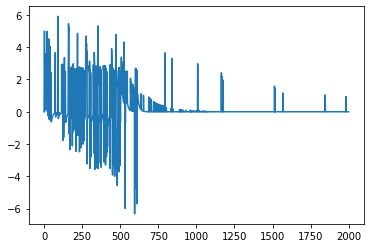

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

# Representamos un agente cualquiere
plt.plot(Grid2[4][6].ERRORES)

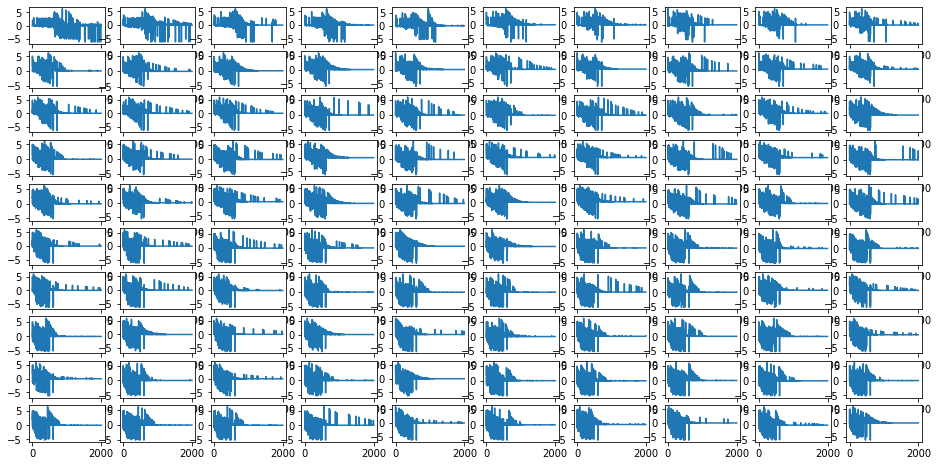

In [ ]:
# REPRESENTAMOS GRÁFICAMENTE LA EVOLUCIÓN EN EL APRENDIZAJE DE CADA CELDA
# -----------------------------------------------------------------------
filas    = size
columnas = size
plt.figure(figsize=(16,8))
for fila in range(filas):
    for columna in range(columnas):
        indice = columnas*fila + columna
        plt.subplot(filas, columnas, indice + 1)
        plt.plot(Grid2[fila+1][columna+1].ERRORES)
#plt.subplots_adjust(wspace=0.5)        
plt.show()

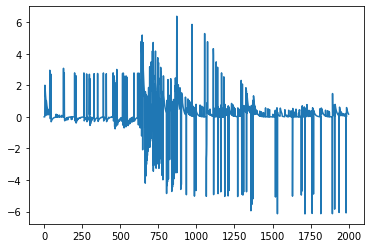

In [ ]:
# Representamos un agente cualquiera
plt.plot(Grid2[1][1].ERRORES)

## Representamos gráficamente la evolución del error en todos los agentes.

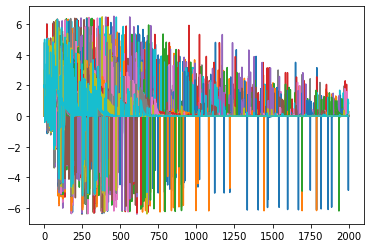

In [ ]:
# Utilizamos la forma más simple de algoritmo SARSA, que en multiagentes no suele converger
# Se observan fluctuaciones altas del ERROR incluso a iteraciones elevadas 

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

for i in range(1,size+1,+1):
    for j in range(1,size+1,+1):
      plt.plot(Grid2[i][j].ERRORES)


## **4). La "Matriz Q" que hemos estimado.**

In [ ]:
# Matriz Q con los valores de cada ACCIÓN en cada ESTADO
# en uno de los agentes (Por ejemplo el (3,4))
matriz_Q = Grid2[4][6].Q() 
matriz_Q

array([[5.56666508, 6.66666667],
       [2.79084251, 0.35712189],
       [5.54184333, 5.66666545]])

## Representamos gráficamente la Matriz Q (que es la que le sirve al agente para tomar decisiones).

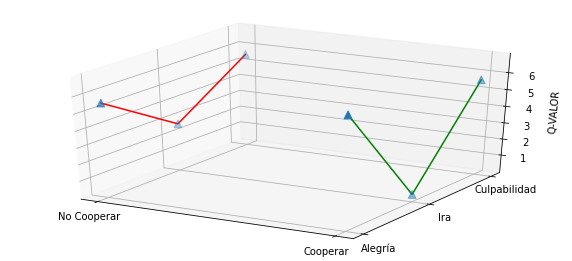

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import xticks
from matplotlib.pyplot import yticks
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(211, projection ='3d')

rango_acciones  = np.arange(0,2)
rango_emociones = np.arange(0,3)

X, Y = np.meshgrid(rango_acciones, rango_emociones)
Z    = matriz_Q
ax.scatter3D(X, Y, Z, marker='^', s=60)

ax.plot3D([0,0,0], [0,1,2], Z[:,0], 'red')
ax.plot3D([1,1,1], [0,1,2], Z[:,1], 'green')
#ax.set_xlabel('ESTRATEGIA')
#ax.set_ylabel('EMOCIONES')
ax.set_zlabel('Q-VALOR')
locs, labels = xticks()
locs, labels = yticks()
xticks([0, 1], ['No Cooperar', 'Cooperar'])
yticks([0, 1, 2], ['Alegría', 'Ira', 'Culpabilidad'])

plt.show()

# **5). Creamos una animación con la evolución emocional y de la cooperación**


<function matplotlib.pyplot.close>

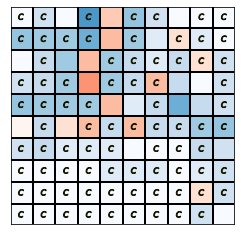

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.animation as FuncAnimation
from matplotlib import animation, rc
rc('animation',html='html5')
import numpy as np
import pandas as pd
%matplotlib inline

# ASOCIAMOS COLORES A EMOCIONES para posteriormente dibujarlas
cmaps = []
cmaps.append(mpl.cm.Blues_r)      # Culpabilidad (azul)    => 0 
cmaps.append(mpl.cm.Greens_r)     # Alegría      (verde)   => 1
cmaps.append(mpl.cm.Reds_r)       # Ira          (rojo)    => 2
cmaps.append(mpl.cm.Oranges_r)    # Miedo        (naranja) => 3
cmaps.append(mpl.cm.Greys_r)      # Tristeza     (gris)    => 4
cmaps.append(mpl.cm.Purples_r)    # Envidia      (púrpura) => 5

# CONSTRUIMOS UNA MALLA DEL TAMAÑO DE LAS MATRICES para luego utilizarla en el dibujo
x = np.arange(0,size)
y = np.arange(0,size)
malla_dibujo = np.meshgrid(x,y)

# Fijamos el tamaño de la ventana en relación al tamaño del GRID
ratio = 0.4
fig, axes = plt.subplots(figsize=(ratio*size,ratio*size))
axes.set_facecolor("black")
axes.get_xaxis().set_visible(False)
axes.get_yaxis().set_visible(False)


def update(i):
  acciones, emociones, intensidad = env.step()
  acciones_   = acciones[1:size+1,1:size+1]
  emociones_  = emociones[1:size+1,1:size+1]
  intensidad_ = intensidad[1:size+1,1:size+1]

  # Se degrada el color según baja el nivel de intensidad
  colores     = [cmaps[color](intensidad) for color,intensidad in zip(emociones_.flatten(),intensidad_.flatten())]

  #color_amarillo =  [(0.990,0.990,0,1) if Coopera else (0,0,0,0) for Coopera in acciones.flatten()]
  color_negro   =  [(0.090,0.090,0,1) if Coopera else (0,0,0,0) for Coopera in acciones_.flatten()]

  dibujo = axes.scatter(*malla_dibujo, marker='s', s=380)
  dibujo.set_facecolor(colores)
  # Sobreimpresionamos una 'C' cuando el agente COOPERA
  dibujo2 = axes.scatter(*malla_dibujo, marker='$C$')
  #dibujo2.set_facecolor(color_amarillo)
  dibujo2.set_facecolor(color_negro)
  return axes

# Creamos una animación con 40 ejecuciones (frames=40), y la separación entre los
# frames es de 1 segundo (interval=1000)
animacion = animation.FuncAnimation(fig, update, frames=40, interval=1000)
plt.close



## Visionamos la animación. Los códigos de color son:    # 
Culpabilidad (azul)    <BR>
Alegría      (verde)   <BR>
Ira          (rojo)    <BR>
(*La emoción será tanto más intensa cuanto mayor sea la unanimidad
en la respuesta de los vecinos. Esto se refleja en un color más fuerte*)
## Y dentro de cada celda:# 
C = Cooperacion

In [ ]:
animacion